In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
        
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)


# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['nitrate'][2015][:]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['nitrate']

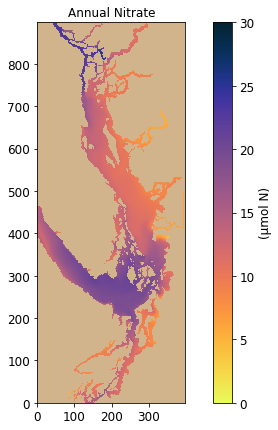

In [6]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=30
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate']['mean']))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Annual Nitrate')
fig.colorbar(m0,ax=ax,label='(\u03bcmol N)')

In [7]:
#years, months, data
monthly_array_nitrate_surface_SSslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_SSslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]




(5, 12)


<ipython-input-8-7109c3ea734d>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_nitrate_surface_SSslice, axis = 2),axis = 2)


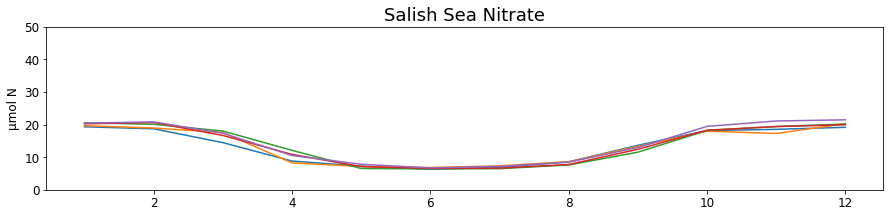

In [8]:
monthly_array_nitrate_surface_SSslice[monthly_array_nitrate_surface_SSslice == 0 ] = np.nan
monthly_array_nitrate_surface_SSslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_SSslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_SSslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_SSslicemean[i,:],label=2015+i)
    ax.set_title('Salish Sea Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

Text(0, 0.5, 'μmol N')

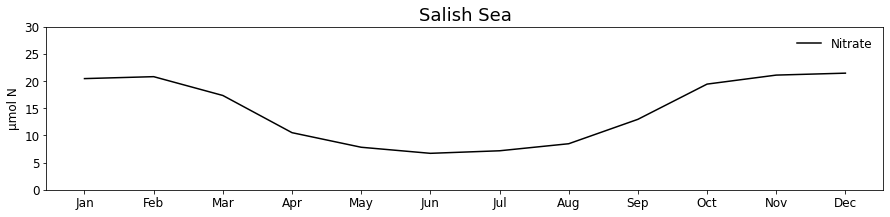

In [9]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named

nitrate=(monthly_array_nitrate_surface_SSslicemean[i,:])



ax.plot(np.arange(1,13), nitrate,label='Nitrate',color='k',)

ax.set_title('Salish Sea',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,30)
ax.set_ylabel('\u03bcmol N')



### Northern SoG

In [10]:
#years, months, data
monthly_array_nitrate_surface_NSOGslice = np.zeros([5,12,50,40])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(650,700), 'x': slice(140,180)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_NSOGslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


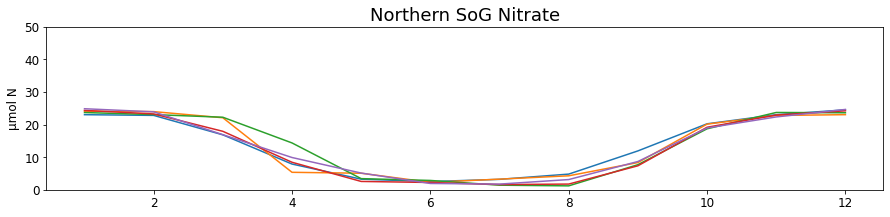

In [11]:
monthly_array_nitrate_surface_NSOGslice[monthly_array_nitrate_surface_NSOGslice == 0 ] = np.nan
monthly_array_nitrate_surface_NSOGslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_NSOGslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_NSOGslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_NSOGslicemean[i,:],label=2015+i)
    ax.set_title('Northern SoG Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

### Baynes Sound

In [12]:
#years, months, data
monthly_array_nitrate_surface_Bslice = np.zeros([5,12,5,5])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(630,635), 'x': slice(123,128)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_Bslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


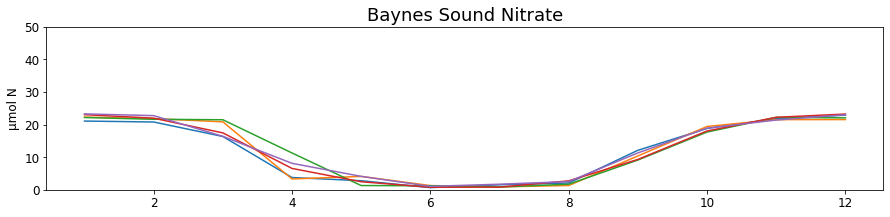

In [13]:
monthly_array_nitrate_surface_Bslice[monthly_array_nitrate_surface_Bslice == 0 ] = np.nan
monthly_array_nitrate_surface_Bslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_Bslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_Bslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_Bslicemean[i,:],label=2015+i)
    ax.set_title('Baynes Sound Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

### Central SoG

In [14]:
#years, months, data
monthly_array_nitrate_surface_CSOGslice = np.zeros([5,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_CSOGslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]




(5, 12)


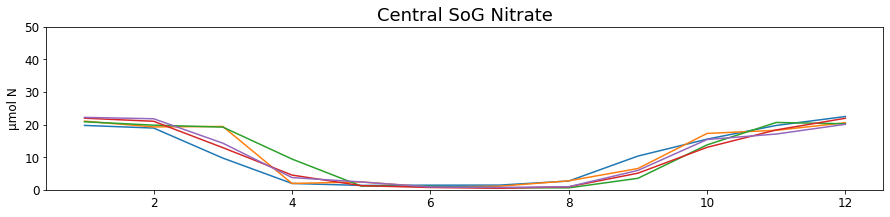

In [15]:
monthly_array_nitrate_surface_CSOGslice[monthly_array_nitrate_surface_CSOGslice == 0 ] = np.nan
monthly_array_nitrate_surface_CSOGslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_CSOGslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_CSOGslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_CSOGslicemean[i,:],label=2015+i)
    ax.set_title('Central SoG Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

### Southern SoG

In [16]:
#years, months, data
monthly_array_nitrate_surface_SSOGslice = np.zeros([5,12,75,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(325,400), 'x': slice(275,325)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_SSOGslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


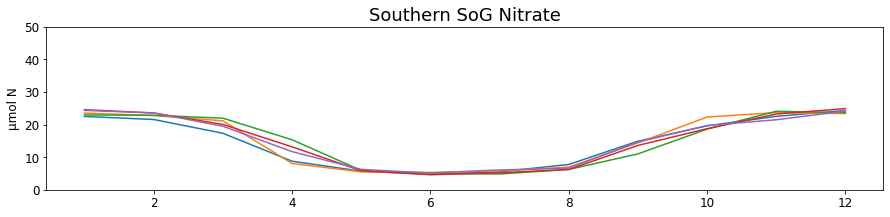

In [17]:
monthly_array_nitrate_surface_SSOGslice[monthly_array_nitrate_surface_SSOGslice == 0 ] = np.nan
monthly_array_nitrate_surface_SSOGslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_SSOGslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_SSOGslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_SSOGslicemean[i,:],label=2015+i)
    ax.set_title('Southern SoG Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

### Juan de Fuca

In [18]:
#years, months, data
monthly_array_nitrate_surface_JDFslice = np.zeros([5,12,200,150])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(250,450), 'x': slice(50,200)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_JDFslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


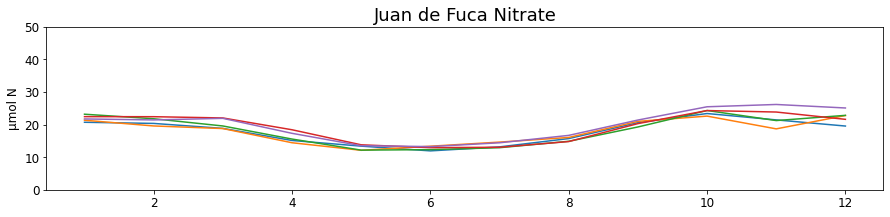

In [19]:
monthly_array_nitrate_surface_JDFslice[monthly_array_nitrate_surface_JDFslice == 0 ] = np.nan
monthly_array_nitrate_surface_JDFslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_JDFslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_JDFslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_JDFslicemean[i,:],label=2015+i)
    ax.set_title('Juan de Fuca Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

### Central Basin Puget Sound

In [20]:
#years, months, data
monthly_array_nitrate_surface_CBslice = np.zeros([5,12,50,55])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(75,125), 'x': slice(225,280)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
    
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_surface_CBslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['nitrate']:
                data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


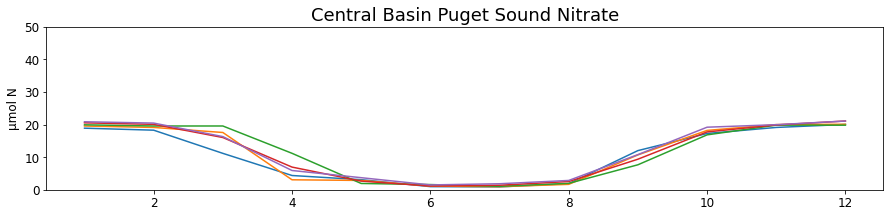

In [21]:
monthly_array_nitrate_surface_CBslice[monthly_array_nitrate_surface_CBslice == 0 ] = np.nan
monthly_array_nitrate_surface_CBslicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_surface_CBslice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_surface_CBslicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13),monthly_array_nitrate_surface_CBslicemean[i,:],label=2015+i)
    ax.set_title('Central Basin Puget Sound Nitrate',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,50)
    ax.set_ylabel('\u03bcmol N')

In [22]:
SSClim=((monthly_array_nitrate_surface_SSslicemean[0,:]+monthly_array_nitrate_surface_SSslicemean[1,:]+\
        monthly_array_nitrate_surface_SSslicemean[2,:]+monthly_array_nitrate_surface_SSslicemean[3,:]+\
        monthly_array_nitrate_surface_SSslicemean[4,:])/5)

In [23]:
NSOGClim=((monthly_array_nitrate_surface_NSOGslicemean[0,:]+monthly_array_nitrate_surface_NSOGslicemean[1,:]+\
        monthly_array_nitrate_surface_NSOGslicemean[2,:]+monthly_array_nitrate_surface_NSOGslicemean[3,:]+\
        monthly_array_nitrate_surface_NSOGslicemean[4,:])/5)

In [24]:
BClim=((monthly_array_nitrate_surface_Bslicemean[0,:]+monthly_array_nitrate_surface_Bslicemean[1,:]+\
        monthly_array_nitrate_surface_Bslicemean[2,:]+monthly_array_nitrate_surface_Bslicemean[3,:]+\
        monthly_array_nitrate_surface_Bslicemean[4,:])/5)

In [25]:
CSOGClim=((monthly_array_nitrate_surface_CSOGslicemean[0,:]+monthly_array_nitrate_surface_CSOGslicemean[1,:]+\
        monthly_array_nitrate_surface_CSOGslicemean[2,:]+monthly_array_nitrate_surface_CSOGslicemean[3,:]+\
        monthly_array_nitrate_surface_CSOGslicemean[4,:])/5)

In [26]:
SSOGClim=((monthly_array_nitrate_surface_SSOGslicemean[0,:]+monthly_array_nitrate_surface_SSOGslicemean[1,:]+\
        monthly_array_nitrate_surface_SSOGslicemean[2,:]+monthly_array_nitrate_surface_SSOGslicemean[3,:]+\
        monthly_array_nitrate_surface_SSOGslicemean[4,:])/5)

In [27]:
JDFClim=((monthly_array_nitrate_surface_JDFslicemean[0,:]+monthly_array_nitrate_surface_JDFslicemean[1,:]+\
        monthly_array_nitrate_surface_JDFslicemean[2,:]+monthly_array_nitrate_surface_JDFslicemean[3,:]+\
        monthly_array_nitrate_surface_JDFslicemean[4,:])/5)

In [28]:
CBClim=((monthly_array_nitrate_surface_CBslicemean[0,:]+monthly_array_nitrate_surface_CBslicemean[1,:]+\
        monthly_array_nitrate_surface_CBslicemean[2,:]+monthly_array_nitrate_surface_CBslicemean[3,:]+\
        monthly_array_nitrate_surface_CBslicemean[4,:])/5)

Text(0, 0.5, 'μmol')

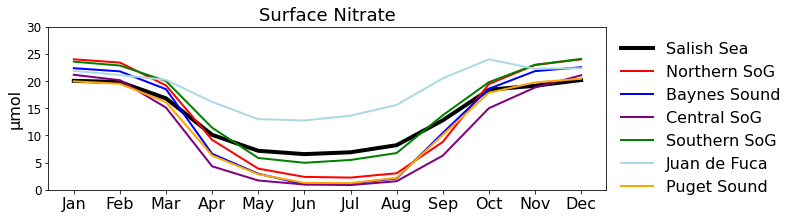

In [29]:
fig, ax = plt.subplots(figsize=(10, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16) #where you replace axs[0] with whatever your axis is named


ax.plot(np.arange(1,13), SSClim,label='Salish Sea',color='k',linewidth=4)
ax.plot(np.arange(1,13), NSOGClim,label='Northern SoG',color='r',linewidth=2)
ax.plot(np.arange(1,13), BClim,label='Baynes Sound',color='blue',linewidth=2)
ax.plot(np.arange(1,13), CSOGClim,label='Central SoG',color='purple',linewidth=2)
ax.plot(np.arange(1,13),SSOGClim,label='Southern SoG',color='green',linewidth=2)
ax.plot(np.arange(1,13), JDFClim,label='Juan de Fuca',color='lightblue',linewidth=2)
ax.plot(np.arange(1,13), CBClim,label='Puget Sound',color='orange',linewidth=2)

ax.set_title('Surface Nitrate',fontsize=18)
ax.legend(frameon=False,bbox_to_anchor=(1,1.0),fontsize=16)
ax.set_ylim(0,30)
ax.set_ylabel('\u03bcmol',fontsize=16)